# Load Data

In [19]:
# Libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [2]:
# Loading data from csv
df = pd.read_csv('Sarcasm_Model_Dataset.csv')
df.head()

# Splitting data into test and train (80:20 split)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=0)

# Frame Classifier

# Audio Classifier

In [ ]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from IPython.display import Audio
from skimage import color

,tone,sarcasm
12,1_1001.wav,False
80,1_11699.wav,True
33,1_2216.wav,False
5,1_410.wav,False
188,2_53.wav,False


In [181]:
#Sources: https://medium.com/@hasithsura/audio-classification-d37a82d6715
         #https://github.com/jeffprosise/Deep-Learning/blob/master/Audio%20Classification%20(CNN).ipynb

#Define helper functions
max_audio_length = 10 #seconds

def get_melspectrogram_db(file_path, sr=None, n_fft=2048, hop_length=512, n_mels=128, fmin=20, fmax=8300, top_db=80):
  wav,sr = librosa.load(file_path,sr=sr)
  if wav.shape[0]<max_audio_length*sr:
    wav=np.pad(wav,int(np.ceil((max_audio_length*sr-wav.shape[0])/2)),mode='reflect') #pad audio by reflecting
  else:
    wav=wav[:max_audio_length*sr]
  spec=librosa.feature.melspectrogram(y=wav, sr=sr, n_fft=n_fft, hop_length=hop_length,n_mels=n_mels,fmin=fmin,fmax=fmax)
  spec_db=librosa.power_to_db(spec,top_db=top_db)
  return spec_db

def spec_to_image(spec, eps=1e-6):
  mean = spec.mean()
  std = spec.std()
  spec_norm = (spec - mean) / (std + eps) #z score normalization
  spec_min, spec_max = spec_norm.min(), spec_norm.max()
  spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
  spec_scaled = spec_scaled.astype(np.uint8)
  return spec_scaled

In [182]:
#Convert .wav files to spectrogram images
audio_dir = 'audio_data'

def get_spec_images(filenames, directory):
    spec_images = []
    for filename in filenames:
        if filename.endswith(".wav"):
            file_path = os.path.join(directory, filename)
            spectrogram = get_melspectrogram_db(file_path)
            spec_image = spec_to_image(spectrogram)
            spec_images.append(spec_image)
    return spec_images

train_spec_images = get_spec_images(train_df['tone'], audio_dir)
train_spec_labels = train_df['sarcasm']

test_spec_images = get_spec_images(test_df['tone'], audio_dir)
test_spec_labels = test_df['sarcasm']

In [183]:
#divide the pixel values by 255
tone_train_norm = np.array(train_spec_images) 
tone_test_norm = np.array(test_spec_images)

#one-hot-encode the labels
tone_train_encoded = to_categorical(train_spec_labels)
tone_test_encoded = to_categorical(test_spec_labels)

In [184]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense, BatchNormalization, Dropout

#Build Model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 862, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='sigmoid'))  # Output layer with 1 unit for binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#model.summary()

In [185]:
batch = 5
epochs = 15

#Fit the model
tone_model = model.fit(tone_train_norm, tone_train_encoded, batch_size=batch, epochs=epochs, validation_split = 0.2)

Epoch 1/15
27/27 [==============================] - 32s 1s/step - loss: 29.7531 - accuracy: 0.4627 - val_loss: 22.5299 - val_accuracy: 0.3824
Epoch 2/15
27/27 [==============================] - 29s 1s/step - loss: 4.2374 - accuracy: 0.5672 - val_loss: 2.3471 - val_accuracy: 0.5294
Epoch 3/15
27/27 [==============================] - 28s 1s/step - loss: 0.6436 - accuracy: 0.5075 - val_loss: 1.6150 - val_accuracy: 0.5294
Epoch 4/15
27/27 [==============================] - 29s 1s/step - loss: 0.6419 - accuracy: 0.4851 - val_loss: 1.2373 - val_accuracy: 0.5294
Epoch 5/15
27/27 [==============================] - 29s 1s/step - loss: 0.6382 - accuracy: 0.5672 - val_loss: 1.0962 - val_accuracy: 0.5000
Epoch 6/15
27/27 [==============================] - 29s 1s/step - loss: 0.6369 - accuracy: 0.5672 - val_loss: 1.0009 - val_accuracy: 0.4706
Epoch 7/15
27/27 [==============================] - 29s 1s/step - loss: 0.6623 - accuracy: 0.5597 - val_loss: 0.6733 - val_accuracy: 0.4706
Epoch 8/15
27/27 [

[]

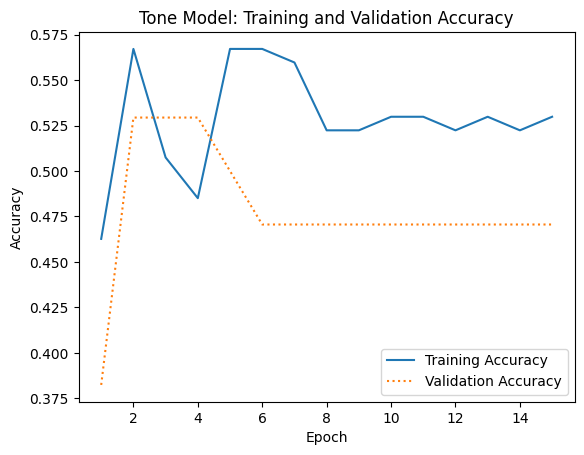

In [186]:
#Train and validation accuracy graph
accuracy = tone_model.history['accuracy']
validation_acc = tone_model.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, '-', label='Training Accuracy')
plt.plot(epochs, validation_acc, ':', label='Validation Accuracy')
plt.title('Tone Model: Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

In [188]:
#make predictions on test set
predictions = model.predict(tone_test_norm)

#Filter to only positive class
tone_predictions = predictions[:, 1]

2/2 [==============================] - 1s 271ms/step
[0.49658754 0.49658754 0.49658754 0.49658754 0.49658754 0.49658754
 0.49658754 0.49658754 0.49658754 0.49658754 0.49658754 0.49658754
 0.49658754 0.49658754 0.49658754 0.49658754 0.49658754 0.49658754
 0.49658754 0.49658754 0.49658754 0.49658754 0.49658754 0.4495652
 0.49658754 0.49658754 0.49658754 0.49658754 0.49658754 0.49658754
 0.49658754 0.49658754 0.49658754 0.49658754 0.49658754 0.49658754
 0.49658754 0.49658754 0.49658754 0.49658754 0.49658754 0.49658754]


# Text Classifer

In [14]:
# Load sentiment classifier
MODEL = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
model = TFAutoModelForSequenceClassification.from_pretrained(MODEL)

# Classify text and add sentiment and score columns to DataFrame
def classify_text(row):
    text = row['text']
    encoded_input = tokenizer(text, return_tensors='tf')
    output = model(**encoded_input)
    scores = output[0][0].numpy()  # Convert TensorFlow tensor to NumPy array
    scores = softmax(scores)
    ranking = np.argsort(scores)[::-1]
    l = config.id2label[ranking[0]]  # Take the label with highest score
    s = np.round(float(scores[ranking[0]]), 4)
    return pd.Series({'sentiment': l, 'score': s})

# Apply classifier to each row in the DataFrame
train_df[['sentiment', 'sentiment_score']] = train_df.apply(classify_text, axis=1)
test_df[['sentiment', 'sentiment_score']] = test_df.apply(classify_text, axis=1)

# Display the DataFrame with new columns
print(train_df.head())
print(test_df.head())

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


           video                                            frame_1  \
104    2_208.mp4  8 8 8 8 8 6 6 6 6 6 7 7 7 6 6 6 5 4 9 23 14 13...   
141    2_575.mp4  8 8 6 3 8 12 14 33 44 58 54 24 37 29 35 38 38 ...   
4      1_276.mp4  123 124 124 92 31 11 14 15 15 16 15 15 15 13 1...   
74   1_10890.mp4  53 58 63 44 59 155 169 168 167 164 163 161 161...   
136    2_514.mp4  72 97 132 169 162 136 81 155 191 175 194 195 2...   

                                               frame_2  \
104  2 2 2 2 2 2 3 3 3 3 3 2 3 2 1 17 20 14 15 15 1...   
141  2 1 5 15 20 19 13 30 49 33 23 32 33 29 24 29 2...   
4    93 30 3 4 5 6 5 5 6 6 6 7 7 7 9 5 4 4 6 4 2 5 ...   
74   59 57 33 59 70 39 40 46 148 166 161 163 164 16...   
136  181 195 222 197 178 210 230 248 230 105 13 15 ...   

                                               frame_3         tone  \
104  6 6 6 7 7 7 8 8 7 6 6 7 7 7 7 7 7 9 7 6 7 9 9 ...    2_208.wav   
141  14 13 3 1 10 21 19 14 38 42 34 27 45 42 30 26 ...    2_575.wav   
4    123 96

In [42]:
# Encode labels
label_encoder = LabelEncoder()
train_df['sarcasm_encoded'] = label_encoder.fit_transform(train_df['sarcasm'])
test_df['sarcasm_encoded'] = label_encoder.fit_transform(test_df['sarcasm'])

# Text preprocessing
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_text_train = tfidf_vectorizer.fit_transform(train_df['text']).toarray()
X_text_test = tfidf_vectorizer.transform(test_df['text']).toarray()

# Convert sentiment labels to numerical values
sentiment_mapping = {'positive': 2, 'neutral': 1, 'negative': 0}
train_df['sentiment_encoded'] = train_df['sentiment'].map(sentiment_mapping)
test_df['sentiment_encoded'] = test_df['sentiment'].map(sentiment_mapping)

# Combine text features with sentiment scores
X_train = np.concatenate((X_text_train, train_df[['sentiment_encoded', 'sentiment_score']].values), axis=1)
y_train = train_df['sarcasm_encoded']
X_test = np.concatenate((X_text_test, test_df[['sentiment_encoded', 'sentiment_score']].values), axis=1)
y_test = test_df['sarcasm_encoded']

In [61]:
# Training parameters
n_epochs = 24
n_batch = 24

# Define neural network architecture
text_model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.25),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
text_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
text_model.fit(X_train, y_train, batch_size=n_batch, epochs=n_epochs, validation_split=0.2)

# Evaluate the model
loss, accuracy = text_model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

Epoch 1/24
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.4606 - loss: 0.6942 - val_accuracy: 0.4706 - val_loss: 0.6942
Epoch 2/24
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6342 - loss: 0.6851 - val_accuracy: 0.5000 - val_loss: 0.6940
Epoch 3/24
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7731 - loss: 0.6767 - val_accuracy: 0.4706 - val_loss: 0.6926
Epoch 4/24
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7974 - loss: 0.6698 - val_accuracy: 0.5000 - val_loss: 0.6912
Epoch 5/24
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8943 - loss: 0.6532 - val_accuracy: 0.5294 - val_loss: 0.6881
Epoch 6/24
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8933 - loss: 0.6320 - val_accuracy: 0.5588 - val_loss: 0.6851
Epoch 7/24
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9377 - loss: 0.6110 - val_accuracy: 0.6176 - val_loss: 0.6813
Epoch 8/24
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9803 - loss: 0.5722 - val_accuracy: 0.6471 - val_loss: 0.6753
Epoch 9

In [62]:
# Predict values for the test set
predictions = text_model.predict(X_test)

# Predicted values are the percentage chance that the sample is sarcastic
print("Predicted Values:")
print(predictions)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted Values:
[[0.01072609]
 [0.5455251 ]
 [0.00740185]
 [0.52083   ]
 [0.00933857]
 [0.11576421]
 [0.975654  ]
 [0.9618984 ]
 [0.9596573 ]
 [0.615184  ]
 [0.921876  ]
 [0.99445546]
 [0.01215159]
 [0.61467785]
 [0.07081493]
 [0.7728272 ]
 [0.00598576]
 [0.42156067]
 [0.98156613]
 [0.9834217 ]
 [0.69449735]
 [0.93922603]
 [0.01179704]
 [0.14391245]
 [0.4052343 ]
 [0.05153637]
 [0.21598184]
 [0.0503226 ]
 [0.59129983]
 [0.03135863]
 [0.01871938]
 [0.9851831 ]
 [0.98319995]
 [0.86148745]
 [0.396978  ]
 [0.06244064]
 [0.6004945 ]
 [0.89363825]
 [0.9924783 ]
 [0.05810065]
 [0.05217709]
 [0.21538955]]


# Sarcasm Detection Model Using Late Fusion